In [1]:
import time
start_time = time.time()
import os
import numpy as np
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import adam
from keras import models
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time 
import progressbar
from tqdm.notebook import tqdm_notebook

Using TensorFlow backend.


In [2]:
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [3]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
df = pd.read_csv('../../Dataset_original_AMLS_19-20/cartoon_set/labels.csv', sep = '\t')
df = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[1]])
df['face_shape'] = df['face_shape'].apply(str)
df

,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png
...,...,...
9995,2,9995.png
9996,3,9996.png
9997,2,9997.png
9998,2,9998.png


In [23]:
img = ('../../Dataset_original_AMLS_19-20/cartoon_set/img')
# training, testing = train_test_split(df, random_state=0)
training, validating = np.split(df.sample(frac=1), [int(0.9*len(df)),]) #splitting at n-array
print(training, validating, testing)

     face_shape file_name
576           1   576.png
4749          1  4749.png
1286          2  1286.png
4767          3  4767.png
6925          4  6925.png
...         ...       ...
7478          1  7478.png
5353          0  5353.png
3938          0  3938.png
4442          2  4442.png
8002          4  8002.png

[9000 rows x 2 columns]      face_shape file_name
1414          0  1414.png
1711          0  1711.png
9847          1  9847.png
3590          3  3590.png
2492          2  2492.png
...         ...       ...
4257          4  4257.png
8213          1  8213.png
5831          4  5831.png
1529          4  1529.png
9093          1  9093.png

[1000 rows x 2 columns]      face_shape file_name
3499          4  3499.png
4386          1  4386.png
8771          3  8771.png
7215          2  7215.png
3189          1  3189.png
...         ...       ...
1525          2  1525.png
8391          4  8391.png
5703          4  5703.png
616           3   616.png
5615          0  5615.png

[1000 rows x 

In [24]:
# set up data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.2,
    horizontal_flip=True,
    vertical_flip=True   
)

# # get batches of training images from the df
# train_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# validate_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# Get batches of training dataset from the dataframe
print("Training Dataset Preparation: ")
train_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training') 
   
# Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparation: ")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = validating, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training')

Training Dataset Preparation: 
Found 7200 validated image filenames belonging to 5 classes.

Validation Dataset Preparation: 
Found 800 validated image filenames belonging to 5 classes.


In [120]:
# starting point 
my_model= models.Sequential()

# Add first convolutional block
my_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                    input_shape=(30,30,3))) #height, width, depth
my_model.add(MaxPooling2D((2, 2), padding='same'))
# second block
my_model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #Convolution: filters, kernel_size that specifies the height and width of the 2D convolution window, p padding layers so dimensions of input = output
my_model.add(MaxPooling2D((2, 2), padding='same'))
# third block
my_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
my_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))

# make predictions
my_model.add(Flatten())
my_model.add(Dense(5, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
my_model.summary()
# compile model 
my_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 128)        

In [121]:
# # use early stopping to optimally terminate training through callbacks

# es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# # save best model automatically
# mc= ModelCheckpoint('/../../dataset/cartoon_set', monitor='val_loss', 
#                     mode='min', verbose=1, save_best_only=True)
# cb_list=[es,mc]

In [122]:
# batch_size = 32
history = my_model.fit_generator(
                                train_generator,
                                epochs=11,
                                steps_per_epoch=train_generator.samples // train_generator.batch_size, #187.5 batches, each 32 samples, 4687.5 batches in total for epoch of 40
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // validation_generator.batch_size
                                )

Epoch 1/11
225/225 [==============================] - 73s 324ms/step - loss: 1.4758 - accuracy: 0.2826 - val_loss: 1.1887 - val_accuracy: 0.3837
Epoch 2/11
225/225 [==============================] - 75s 332ms/step - loss: 1.1078 - accuracy: 0.4701 - val_loss: 1.0646 - val_accuracy: 0.5600
Epoch 3/11
225/225 [==============================] - 71s 317ms/step - loss: 0.7816 - accuracy: 0.6507 - val_loss: 0.7112 - val_accuracy: 0.7237
Epoch 4/11
225/225 [==============================] - 72s 321ms/step - loss: 0.5461 - accuracy: 0.7676 - val_loss: 0.8280 - val_accuracy: 0.7775
Epoch 5/11
225/225 [==============================] - 72s 318ms/step - loss: 0.4254 - accuracy: 0.8304 - val_loss: 0.5998 - val_accuracy: 0.8213
Epoch 6/11
225/225 [==============================] - 75s 333ms/step - loss: 0.3454 - accuracy: 0.8686 - val_loss: 0.2474 - val_accuracy: 0.8263
Epoch 7/11
225/225 [==============================] - 75s 334ms/step - loss: 0.2838 - accuracy: 0.8903 - val_loss: 0.4521 - val_ac

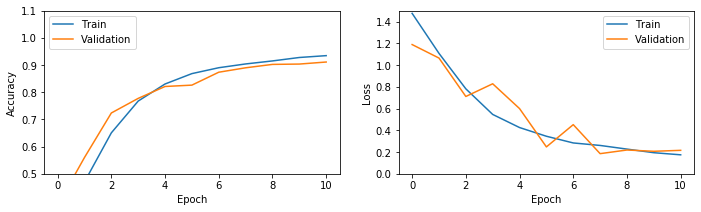

In [123]:
plt.figure(figsize=(18, 3))

plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.5,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(132)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,1.5])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.savefig("Custom_Keras_ODSC.png", dpi=300)

In [124]:
from keras.models import load_model

modelFile = 'my_CNN.h5'

# model_path = os.path.abspath(os.curdir)
# file_path = os.path.join(model_path, modelFile)
my_model.save(modelFile)

In [125]:
os.getcwd()

'C:\\Users\\User\\Desktop\\4th_year_AMLS\\AMLS_19-20_ChinYangTan_16053203\\Project_AMLS_19-20_16053203\\Notebook\\B1'

In [126]:
df2 = pd.read_csv('../../Dataset_test_AMLS_19-20/cartoon_set_test/labels.csv', sep = '\t')
df2 = df2.drop(columns = [df2.columns[0]]).drop(columns = [df2.columns[1]])
df2['face_shape'] = df2['face_shape'].apply(str)
df2

,face_shape,file_name
0,1,0.png
1,4,1.png
2,2,2.png
3,2,3.png
4,3,4.png
...,...,...
2495,4,2495.png
2496,4,2496.png
2497,4,2497.png
2498,4,2498.png


In [127]:
img = ('../../Dataset_test_AMLS_19-20/cartoon_set_test/img')

In [128]:
# saved_model = load_model(modelFile)
# test_generator = data_generator.flow_from_dataframe(
#         dataframe = testing, directory = img,
#         x_col = "file_name", y_col = "face_shape",
#         batch_size=1,
#         class_mode='categorical', target_size=(30, 30),
#         shuffle=False)
# test_steps = test_generator.samples
# print(test_steps)

saved_model = load_model(modelFile)
test_generator = data_generator.flow_from_dataframe(
        dataframe = df2, directory = img,
        x_col = "file_name", y_col = "face_shape",
        batch_size=1,
        class_mode='categorical', target_size=(30, 30),
        shuffle=False)
test_steps = test_generator.samples
print(test_steps)

Found 2500 validated image filenames belonging to 5 classes.
2500


In [129]:
test_generator.reset()
pred=saved_model.predict_generator(test_generator, verbose=1, steps=test_steps)
# determine the maximum activation value for each sample
predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)
# label each predicted value to correct gender
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# # format file names to simply male or female
# filenames=test_generator.filenames
# filenz=[0]
# for i in range(0,len(filenames)):
#     filenz.append(filenames[i].split('\\')[0])
# filenz=filenz[1:]

# # determine the test set accuracy
# match=[]
# for i in range(0,len(filenames)):
#     match.append(filenz[i]==predictions[i])
# match.count(True)/1000



2500/2500 [==============================] - 32s 13ms/step


In [130]:
import sklearn.metrics as metrics

[[444  27   9  17   3]
 [ 57 421   2  18   2]
 [  3   1 492   3   1]
 [  4  26   3 458   9]
 [  7   6   2   6 479]]

Confusion Matrix


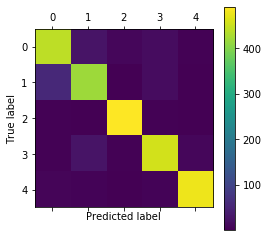

[[0.1776 0.0108 0.0036 0.0068 0.0012]
 [0.0228 0.1684 0.0008 0.0072 0.0008]
 [0.0012 0.0004 0.1968 0.0012 0.0004]
 [0.0016 0.0104 0.0012 0.1832 0.0036]
 [0.0028 0.0024 0.0008 0.0024 0.1916]]

Confusion Matrix (normalised)


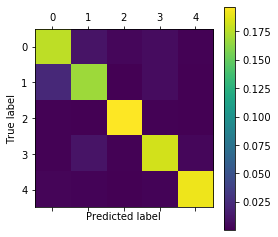

Classification report

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       500
           1       0.88      0.84      0.86       500
           2       0.97      0.98      0.98       500
           3       0.91      0.92      0.91       500
           4       0.97      0.96      0.96       500

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500

Accuracy achieved: 0.9176 ♡♡♡


In [131]:
#confusion matrix and classification report

#Y_pred = my_model.predict_generator(test_generator, test_generator.samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)


#target_names = ['0','1','2','3','4']
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))

cm = confusion_matrix(test_generator.classes, predicted_class_indices)

print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')
plt.show()


cm2 = confusion_matrix(test_generator.classes, predicted_class_indices, normalize='all')

print(cm2)
plt.matshow(cm2)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix (normalised)')
plt.show()

print('Classification report\n')
print(classification_report(test_generator.classes, predicted_class_indices))
print('Accuracy achieved:', accuracy_score(test_generator.classes, predicted_class_indices), '\u2661''\u2661''\u2661')

In [132]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 58267.900737285614 seconds ---
